# Check dataset

In [1]:
import sys,os,glob,time,copy,warnings,cProfile,shutil,matplotlib
from IPython import display
import h5py as h5
import numpy as np
import scipy.fftpack
import scipy.signal
import scipy.io as io
import skimage.restoration as deconv
from math import cos, sin, radians
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen, OSM
import cartopy.feature as cfeature
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.taup import TauPyModel
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
matplotlib.rcParams['pdf.fonttype'] = 42


from pyproj import Geod

import m_pycorr.mods.dd as dd
import m_pycorr.mods.lang as lang

import m_manage_data as m_mod

import ipdb

%matplotlib widget

In [2]:
path          = "data_4.0hz/events/"
list_of_files = glob.glob(path + '/*/*.h5')

lat    = []
lon    = []
id_sta = []
ch     = []

list_of_files.sort()

for i_file in list_of_files:
#i_file = 'data_4.0hz/events/glob_03/2014-12-09T12-00-00.000000Z_mww_6.0.h5'
    h5f   = h5.File(i_file,'r')
    dic   = m_mod.recursively_load_dic_from_h5(h5f, path='/_metadata/sta/')
    dic_ev= m_mod.recursively_load_dic_from_h5(h5f, path='/_metadata/ev/')

    for net_lvl in dic.keys():
        for sta_lvl in dic[net_lvl]:
            lat.append(dic[net_lvl][sta_lvl]['lat'][()])
            lon.append(dic[net_lvl][sta_lvl]['lon'][()])
            id_sta.append(net_lvl + '/' + sta_lvl)
            isN =  str(int('/' + net_lvl + '/' + sta_lvl + '/N' in h5f))
            isE =  str(int('/' + net_lvl + '/' + sta_lvl + '/E' in h5f))   
            isZ =  str(int('/' + net_lvl + '/' + sta_lvl + '/Z' in h5f)) 
            ch.append( isZ + isN + isE )
    
    h5f.close()
    #dd.dd(dic)

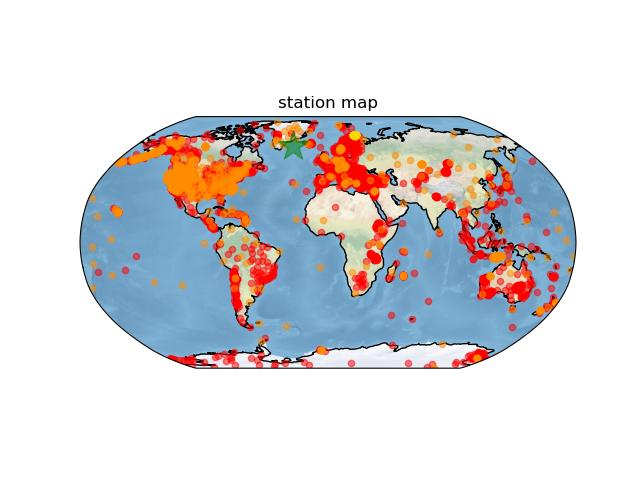

In [3]:
plt.close('all')
m_mod.mmap(111,lon,lat,ch=ch,xylabel=True,ev=[dic_ev['lon'], dic_ev['lat']],res=2)
plt.scatter(dic_ev['lon'], dic_ev['lat'], marker='*', c='g', s=500,transform=ccrs.PlateCarree(),cmap='plasma_r',alpha=0.5)

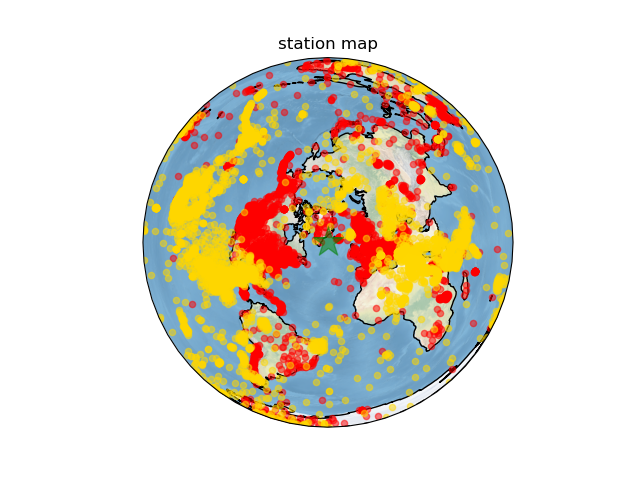

In [4]:
plt.close('all')

vec_dist  = np.zeros([len(id_sta),1])
vec_az    = np.zeros([len(id_sta),1])
vec_baz   = np.zeros([len(id_sta),1])

for counterA, staA in enumerate(id_sta):
    (vec_dist[counterA],vec_az[counterA],vec_baz[counterA]) = gps2dist_azimuth(dic_ev['lat'], dic_ev['lon'], lat[counterA], lon[counterA])

geoid = Geod(ellps="WGS84")    
term_lon,term_lat,term_baz = geoid.fwd(lon, lat, vec_baz+180.,vec_dist) 

plt.close('all')
m_mod.mmap(111,lon,lat,ch=None,xylabel=True,res=2,proj='azi',ev=[dic_ev['lon'], dic_ev['lat']])
plt.scatter(term_lon,term_lat, marker='o', c='gold', s=20,transform=ccrs.PlateCarree(),cmap='plasma_r',alpha=0.5)
plt.scatter(dic_ev['lon'], dic_ev['lat'], marker='*', c='g', s=500,transform=ccrs.PlateCarree(),cmap='plasma_r',alpha=0.5)


In [5]:
mat_dist   = np.zeros([len(id_sta),len(id_sta)])
bool_dist  = np.zeros([len(id_sta),len(id_sta)])

for counterA, staA in enumerate(id_sta):
    az,baz,mat_dist[:,counterA] = geoid.inv(np.tile(term_lon[counterA],np.array(lon).size), np.tile(term_lat[counterA],np.array(lon).size), lon , lat)
    bool_dist[:,counterA] = (mat_dist[:,counterA] < 0.05*vec_dist[counterA])
    

In [6]:
plt.close('all')

valid_idxA = np.where(np.sum(bool_dist,0)>0)[0]
valid_idxB = np.where(np.sum(bool_dist,1)>0)[0]

m_mod.mmap(111,np.array(lon)[valid_idxA],np.array(lat)[valid_idxA],ch=None,ev=[dic_ev['lon'], dic_ev['lat']],proj='azi',xylabel=True,res=2)


n = 180
col = pl.cm.inferno(np.linspace(0,1,n))

xfil = open('list_xcorr_TEST.txt', 'w')

dist_pair = []
for counterA in valid_idxA:
    for counterB in np.where(bool_dist[:,counterA])[0]:
        xfil.write(id_sta[counterA].replace('/','.') + '_' + id_sta[counterB].replace('/','.') + '\n')
        dist_pair.append(geoid.line_length([lon[counterA],lon[counterB]], [lat[counterA], lat[counterB]])/1000/111.91)
        #col[int(dist_pair[-1])]
        plt.plot([lon[counterA],lon[counterB]], [lat[counterA], lat[counterB]], color=col[int(dist_pair[-1])], linewidth=0.5,alpha=0.25, transform=ccrs.Geodetic())

plt.scatter(np.array(lon)[valid_idxB],np.array(lat)[valid_idxB], marker='o', c='darkviolet', s=20,transform=ccrs.PlateCarree(),cmap='plasma_r',alpha=0.5)
plt.scatter(dic_ev['lon'], dic_ev['lat'], marker='*', c='g', s=500,transform=ccrs.PlateCarree(),cmap='plasma_r',alpha=0.5)

xfil.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
plt.savefig('map_P-PKP_paths.pdf')

In [10]:
plt.close('all')
plt.hist(dist_pair,bins=180)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([   1.,    0.,    1.,    3.,    4.,   30.,    0.,    6.,    2.,
           2.,  205.,  349.,   62.,   52.,   14.,   34.,   62.,   24.,
           3.,    1.,   19.,   33.,    0.,    0.,   39.,  106.,   88.,
          19.,    8.,   16.,    3.,    0.,    4.,    2.,    0.,    0.,
           0.,    2.,   19.,    2.,    0.,    0.,    0.,   12.,   35.,
         125.,    0.,    0.,    4.,    1.,    3.,   84.,   86.,   56.,
         159.,   70.,    9.,    0.,    0.,    0.,    1.,    1.,    0.,
           4.,   14.,   33.,   47.,   34.,   14.,   13.,    2.,    9.,
          16.,   48.,   50.,   55.,   71.,   92.,   84.,   40.,   27.,
           3.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           3.,    4.,    1.,    3.,    4.,   13.,    7.,   12.,   18.,
          19.,    7.,   15.,   73.,  187.,  238.,  161.,   28.,    2.,
           1.,    2.,    1.,    2.,    2.,    7.,    5.,   14.,   28.,
          16.,   20.,   12.,    4.,    2.,    2.,    3.,   10.,   12.,
      

In [11]:
plt.close('all')

model = TauPyModel(model="PREM")
ray_p_pcp=[]
vect_epi_dist =  np.linspace(0,90,181)
for dist in vect_epi_dist:
    #print(dist)
    arrivals = model.get_travel_times(source_depth_in_km=0,
                                  distance_in_degree=dist,
                                  phase_list=["PcP"])
    arr = arrivals[0]
    ray_p_pcp.append(arr.ray_param)
    
    
ray_p_pcp = np.array(ray_p_pcp)
plt.plot(vect_epi_dist,np.array(ray_p_pcp))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
plt.close('all')

ray_to_find = model.get_travel_times(source_depth_in_km=0,
                              distance_in_degree=140,
                              phase_list=["PKIKP","PKP"])[0].ray_param

vect_epi_dist[np.argmin(np.abs(ray_p_pcp-ray_to_find))]



20.0